<a href="https://colab.research.google.com/github/supertulli/ChangeMonitoring/blob/main/PDFChangeDetectorAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

When running for the first interaction, please run the full notebook (Ctrl+F9).

To change the detector parameters and/or test the detector with different processes, edit the identified settings cell, and then run the cell and all cells bellow (Ctrl+F10).

In [ ]:
!git clone https://github.com/supertulli/ChangeMonitoring.git

In [ ]:
%cd ChangeMonitoring

In [ ]:
!pip install -r requirements.txt

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [1]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider

from scipy.stats import beta
import numpy as np


In [2]:
%matplotlib ipympl

def plot_slider_animation(alpha_estimates_list,
                        beta_estimates_list,
                        min_u1s_list,
                        min_u2s_list,
                        min_u3s_list,
                        current_u1s_list,
                        first_frame, last_frame,
                        y_min=0, y_max=100, x_min=0, x_max=0.3):

    framed_time=slice(first_frame, last_frame+1)

    frame_data_list = list(zip(alpha_estimates_list[framed_time], beta_estimates_list[framed_time],
                min_u1s_list[framed_time], min_u2s_list[framed_time], min_u3s_list[framed_time],
                current_u1s_list[framed_time],
                range(first_frame, last_frame+1)))



    a_process, b_process, min_u1, min_u2, min_u3, current_u1, start_time = frame_data_list.pop(0)
    end_time = frame_data_list[-1][-1]

    fig, ax = plt.subplots(figsize=(15,7))

    if (a_process is not None) and (b_process is not None):
        x_process = np.linspace(beta.ppf(0.001, a_process, b_process),beta.ppf(0.999, a_process, b_process), 1000)
        y_process = beta.pdf(x_process, a_process, b_process)
        line_process = ax.plot(x_process, y_process, 'b-', label='distance do reference distribution')[0]
    else:
        line_process = ax.plot([], [], 'b-', label='distance to reference distribution')[0]

    if current_u1 is not None:
        u1_process = ax.axvline(current_u1, ymin=0, ymax= beta.pdf(current_u1, a_process, b_process), color="blue", linestyle="dashdot", label='current u1')
    else:
        u1_process = ax.axvline(0, ymin=0, ymax= 0, color="blue", linestyle="dashdot")

    if min_u1 is not None:
        u1_marker = ax.axvline(min_u1, ymin=0, ymax= beta.pdf(min_u1, a_process, b_process), color="green", alpha=0.5, label="u1_threshold")
        u2_marker = ax.axvline(min_u2, ymin=0, ymax= beta.pdf(min_u2, a_process, b_process), color="orange", alpha=0.5, label="u2_threshold")
        u3_marker = ax.axvline(min_u3, ymin=0, ymax= beta.pdf(min_u3, a_process, b_process), color="red", alpha=0.5, label="u3_threshold")
    else:
        u1_marker = ax.axvline(0, ymin=0, ymax= 0, color="green", alpha=0.5, label="u1_threshold")
        u2_marker = ax.axvline(0, ymin=0, ymax= 0, color="orange", alpha=0.5, label="u2_threshold")
        u3_marker = ax.axvline(0, ymin=0, ymax= 0, color="red", alpha=0.5, label="u3_threshold")
    ax.set(xlim=(x_min, x_max), xlabel='Values of Random Variable X (0, 1)',
        ylim=(y_min,y_max), ylabel='Probability density', title='Beta Distribution of pdf distances to reference distribution')
    time_legend = ax.text(0.9, 0.95, f'time: {start_time}', ha='left', va='top', transform=ax.transAxes,
                    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.legend(loc='lower right')

    # adjust the main plot to make room for the sliders
    fig.subplots_adjust(left=0.25, bottom=0.25)

    # Make a horizontal slider to control the frequency.
    axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    freq_slider = Slider(
        ax=axfreq,
        label='Time step',
        valmin=start_time,
        valmax=end_time,
        valinit=start_time,
    )

    # Plot the beta distribution
    def update(val):

        idx = max(0,int(freq_slider.val)-start_time-1)
        print(idx)
        a_process, b_process, min_u1, min_u2, min_u3, current_u1, time = frame_data_list[idx]

        if (a_process is not None) and (b_process is not None):
            x_process = np.linspace(beta.ppf(0.001, a_process, b_process),beta.ppf(0.999, a_process, b_process), 1000)
            y_process = beta.pdf(x_process, a_process, b_process)
            line_process.set_data(x_process, y_process)
        else:
            line_process.set_data([], [])

        if current_u1 is not None:
            u1_process.set_xdata([current_u1, current_u1])
            u1_process.set_ydata([0,beta.pdf(current_u1, a_process, b_process)])
        else:
            u1_process.set_xdata([0,0])
            u1_process.set_ydata([0,0])

        if min_u1 is not None:
            u1_marker.set_xdata([min_u1,min_u1])
            u1_marker.set_ydata([0,beta.pdf(min_u1, a_process, b_process)])
            u2_marker.set_xdata([min_u2,min_u2])
            u2_marker.set_ydata([0,beta.pdf(min_u1, a_process, b_process)])
            u3_marker.set_xdata([min_u3,min_u3])
            u3_marker.set_ydata([0,beta.pdf(min_u1, a_process, b_process)])
        else:
            u1_marker.set_xdata([0,0])
            u1_marker.set_ydata([0,0])
            u2_marker.set_xdata([0,0])
            u2_marker.set_ydata([0,0])
            u3_marker.set_xdata([0,0])
            u3_marker.set_ydata([0,0])

        time_legend.set_text(f'time: {time}')

        fig.canvas.draw_idle()

    # register the update function with each slider
    freq_slider.on_changed(update)
    # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
    resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', hovercolor='0.975')

    def reset(event):
        freq_slider.reset()

    button.on_clicked(reset)

    plt.show()

In [3]:
from random import gauss

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def gaussian_histogram(mu:float, sigma:float, sample_size:int):
    bin_edges = np.linspace(-10,10,21)
    histogram, _ = np.histogram([gauss(mu, sigma) for _ in range(sample_size)], bins=bin_edges, density=True)
    return pd.Series(histogram)

In [5]:
#####   SETTINGS CELL   #####

############################################################
## Edit this cell to manipulate the test on the detector: ##
## Then, run this cell and the ones below (Ctrl+F10), to  ##
## see the plot depicting the detector behavior.          ##
############################################################

# sampling parameters
histogram_sample_size = 3000

# base process parameters
base_mu = 2
base_var = 1
base_length = 300 # in time instances

# new process parameters
new_mu = 2.1
new_var = 1
new_length = 200

# detector parameters
ref_size = 30
monitor_size = 50
method = "window"

#slider parameters
first_frame = 275
last_frame = 450
y_max = 250
x_max = 0.05

In [6]:
from src.change_detector.corrected_change_detector import PDFChangeDetector

change_detector = PDFChangeDetector(reference_size=ref_size,monitor_size=monitor_size,method=method)

detection_status_list = []
alpha_estimates_list = []
beta_estimates_list = []
u1_min_list = []
u2_min_list = []
u3_min_list = []
current_u1_list = []

for i in range(base_length):
    new_pdf = gaussian_histogram(base_mu, base_var, sample_size=histogram_sample_size)
    detect_response = change_detector.detect_change(new_pdf)
    
    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)
    
    print("Status: ", detect_response.state.name, 
        "| Alpha :", detect_response.alpha_estimate, 
        "| Beta", detect_response.beta_estimate, 
        "\n***\n")


for i in range(new_length):
    new_pdf = gaussian_histogram(new_mu, new_var, sample_size=histogram_sample_size)
    detect_response = change_detector.detect_change(new_pdf)
    
    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)
    
    print("Status: ", detect_response.state.name, 
        "| Alpha :", detect_response.alpha_estimate, 
        "| Beta", detect_response.beta_estimate, 
        "\n***\n")

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : None | Beta None 
***

Status:  LEARNING | Alpha : Non

In [7]:
data = pd.DataFrame([detection_status_list, alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list]).T
data

,0,1,2,3,4,5,6
0,LEARNING,None,None,None,None,None,None
1,LEARNING,None,None,None,None,None,None
2,LEARNING,None,None,None,None,None,None
3,LEARNING,None,None,None,None,None,None
4,LEARNING,None,None,None,None,None,None
...,...,...,...,...,...,...,...
495,IN_CONTROL,13.016493,589.884556,0.025574,0.032458,0.040752,0.027401
496,IN_CONTROL,13.436894,605.006802,0.025574,0.032458,0.040752,0.027485
497,IN_CONTROL,13.419107,608.00369,0.025574,0.032458,0.040752,0.027321
498,IN_CONTROL,15.31179,684.545197,0.025574,0.032458,0.040752,0.027317


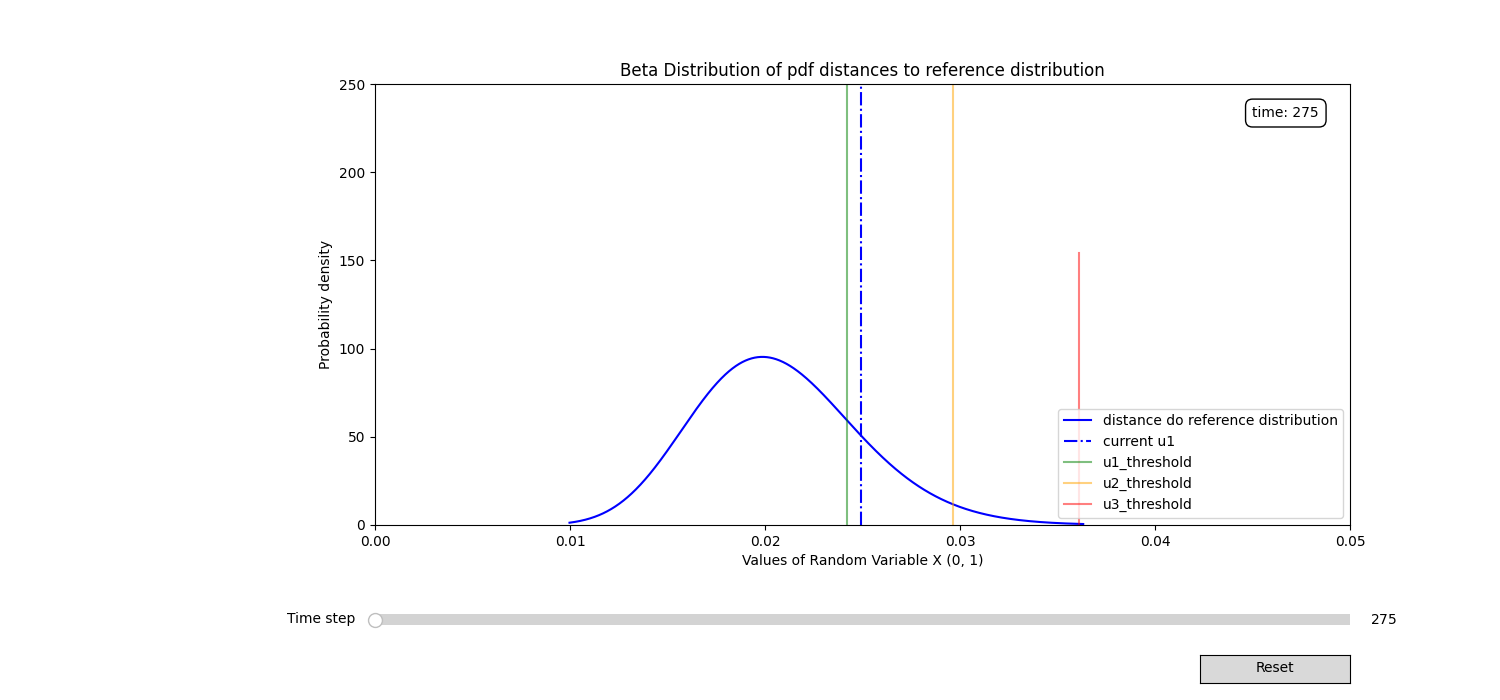

In [8]:
plot_slider_animation(alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list, first_frame=first_frame, last_frame=last_frame, y_max=y_max, x_max=x_max)